<h1> Prédiction de crédit

Nicolas Pogeant

---

## 1. Introduction et données

L'idée de ce projet est de réussir à comprendre le profil des individus tendant à se voir refuser un crédit et de savoir si cela est possible à partir du jeu de données utilisé.

Pour cela, les données choisies sont celles provennant d'un [dataset d'Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/) portant sur des informations concernant des individus ayant oui ou non été accepté dans leur demande de crédit.

On va chercher à rendre compte de ce qui caractérise le mieux un refus ou un accord de crédit mais surtout de prédire si un individu sera plus probable d'en obtenir un ou non.

### Table des matières 

- [1. Introduction et données](#1.-Introduction-et-données)
    - [1.1 Récupération de la base de données](#1.1-Récupération-de-la-base-de-données)
    - [1.2 Observation des données](#1.2-Observation-des-données)
    - [1.3 Premier traitement des données](#1.3-Premier-traitement-des-données)
    

- [2. Analyse Statistique](#2.-Analyse-Statistique)
    - [2.1 A l'aide de tableaux croisés](#2.1-A-l'aide-de-tableaux-croisés)
    - [2.2 En réalisant une analyse univariée](#2.2-En-réalisant-une-analyse-univariée)
    - [2.3 Data processing](#2.3-Data-processing)
    

- [3. Prédiction et modélisation](#3.-Prédiction-et-modélisation)
    - [3.1 Modélisation du problème à partir d'une régression logistique](#3.1-Modélisation-du-problème-à-partir-d'une-régression-logistique])
    - [3.2 Modification des données d'apprentissage afin d'améliorer le modèle](#3.2-Modification-des-données-d'apprentissage-afin-d'améliorer-le-modèle)

### Les librairies utilisées

Commençons par importer toutes les bibliotheques dont nous avons besoin dans le notebook.

- [Numpy](www.numpy.org) - Le paquet fondamental pour le calcul scientifique avec Python.
- [StatsModels](http://www.statsmodels.org/stable/index.html) - Récolte de nombreux modèles statistiques.
- [Pandas](https://pandas.pydata.org) - Tableaux numériques permettant de manipuler facilement les données.
- [Matplotlib](http://matplotlib.org) - Outils pour le traçage en 2D/3D et pour la réalisation d'animations.
- [Seaborn](https://seaborn.pydata.org/index.html) - Interface de haut niveau pour l'affichage de statistiques.
- [Scikit-Learn](https://scikit-learn.org) - Bibliothèque libre Python destinée à l'apprentissage automatique.
- [Statsmodels](https://www.statsmodels.org) - Package Python qui permet aux utilisateurs d'explorer des données, d'estimer des modèles statistiques et d'effectuer des tests statistiques.


In [1]:
#Librairies d'analyse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Librairies de Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

import warnings; warnings.simplefilter('ignore')

### 1.1. Récupération des données

On commence par charger les données du fichier `loan_data_set.csv` dans un **data frame** par la méthode `read_csv()`.

In [2]:
#Import du dataset 
credit = pd.read_csv("loan_data_set.csv")
credit.shape

(614, 13)

Le jeu de données comprend **13 colonnes** et **614 lignes**.

Regardons comment se présente le jeu de données, les différentes colonnes, à quoi correspondent les variables.

In [3]:
#Point de vue aléatoire sur le jeu de données
credit.sample(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
161,LP001562,Male,Yes,0,Graduate,No,7933,0.0,275.0,360.0,1.0,Urban,N
300,LP001964,Male,Yes,0,Not Graduate,No,1800,2934.0,93.0,360.0,0.0,Urban,N
42,LP001123,Male,Yes,0,Graduate,No,2400,0.0,75.0,360.0,NaN,Urban,Y


In [4]:
#Les différentes colonnes 
print("Les colonnes sont les suivantes :", *credit.columns, sep='\n - ')

Les colonnes sont les suivantes :
 - Loan_ID
 - Gender
 - Married
 - Dependents
 - Education
 - Self_Employed
 - ApplicantIncome
 - CoapplicantIncome
 - LoanAmount
 - Loan_Amount_Term
 - Credit_History
 - Property_Area
 - Loan_Status


In [5]:
#Obtenir les valeurs uniques des colonnes pertinentes (hors tranche de valeur énorme)
colonnes = ('Gender',  'Married',  'Dependents',  'Education',  'Self_Employed',  
          'Loan_Amount_Term',  'Credit_History',  'Property_Area',  'Loan_Status' )

#On met de coté les NaN pour le moment
for col in colonnes:
    unique = credit[col].unique()
    print(unique, sep='\n')

['Male' 'Female' nan]
['No' 'Yes' nan]
['0' '1' '2' '3+' nan]
['Graduate' 'Not Graduate']
['No' 'Yes' nan]
[360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.]
[ 1.  0. nan]
['Urban' 'Rural' 'Semiurban']
['Y' 'N']


Le détail des variables est le suivant:

- **Loan ID** correspond à l'ID de la demande de prêt.<br>
- **Gender*** signifie le genre, "Female" ou "Male".<br>
- **Married** correspond à la donnée de mariage et prend donc deux valeurs possibles : Oui ou Non.<br>
- **Dependents** est égal au nombre de personnes à charge que l'individu à, il peut en avoir de 0 à 3+.
- **Education** correspond au niveau d'éducation, Graduate ou Not Graduate.
- **Self_Employed** signifie si la personne est un indépendant dans le monde du travail ou non, valeur Yes, No.
- **Loan_Amount_Term** correpsond à le durée du prêt, il prend plusieurs valeurs, de 12 mois à 320 mois, uniquement dans la table de 12 (en année par conséquent).
- **Credit_History** admet un crédit obtenu dans le passé, valeur binaire 1 ou 0.
- **Property_Area** prend les valeurs Urban, Rural et Semiurban pour définir la zone de logement de la personne.
- **Loan_Status** correspond à l'acceptation ou au refus de la demande de prêt, Yes ou No, il constituera la variable dépendante ou expliquée.

### 1.2. Observation des données
Il s'agit de comprendre les données et de les préparer afin d'élaborer un modèle performant.

In [6]:
#Information concernant le dataset
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Il y a donc effectivement **13 colonnes** de types différents (quantitatives ou qualitatives). Le fait que les types de variables soient différents impliquera par la suite de les rendre analysables en transformant les variables dites catégorielles notamment.

On constate aussi que l'entièreté des valeurs de certaines colonnes n'est pas égales au nombre total de lignes, ce qui signifie qu'il y a des valeurs manquantes comme nous l'avons aperçue dans les valeurs unique précédemment. 

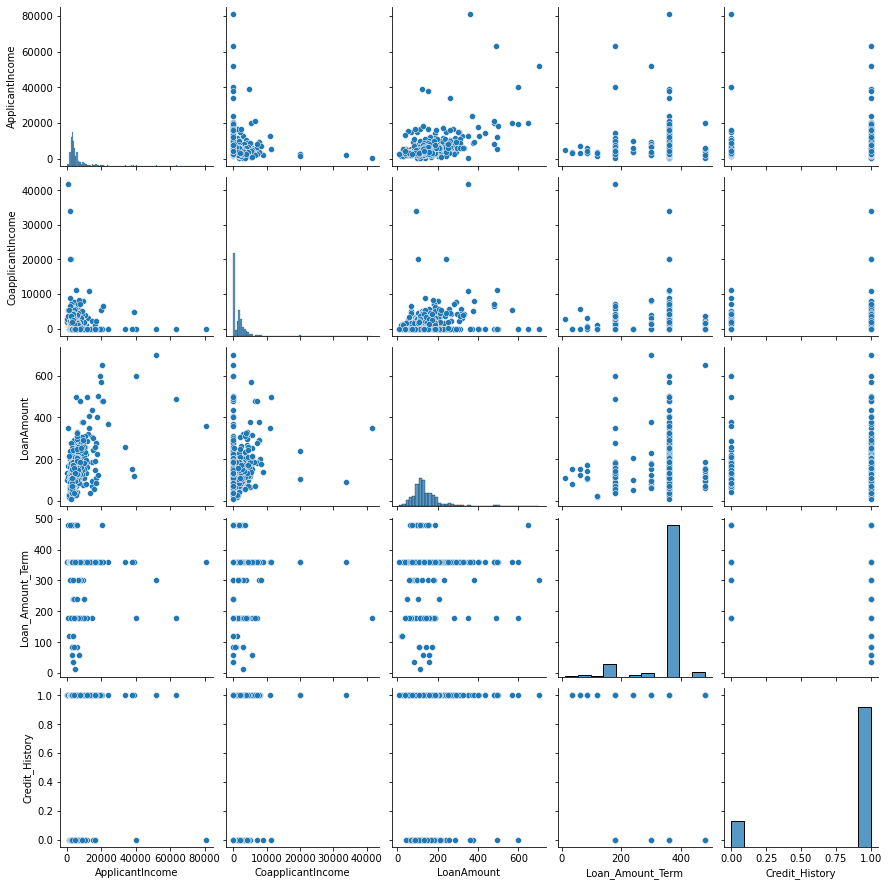

In [7]:
#Distribution des données
sns.pairplot(credit)

Ce graphique à pour but de mettre en avant la distribution des variables par rapport à elle même et par rapport aux autres. On constate tout de même qu'il est **difficile d'observer de la linéarité entre les variables** notamment par la présence de beaucoup de variables catégorielles.

On observe qu'il y a **beaucoup plus d'individu avec un historique de crédit égal à 1 plutot qu'à 0**. Cette variable sera importante dans la suite de l'analyse.

Regardons plus précisément la distribution à l'intérieur de certaines colonnes.

In [8]:
#Part d'hommes et de femmes
hommes = credit['Gender'][credit['Gender']=='Male'].count() / credit['Gender'].count()
femmes = credit['Gender'][credit['Gender']=='Female'].count() / credit['Gender'].count()
print('Proportion d\'hommes: {:2.2f} %'.format(hommes*100))
print('Proportion de femmes: {:2.2f} %'.format(femmes*100))

Proportion d'hommes: 81.36 %
Proportion de femmes: 18.64 %


In [9]:
#Part de crédits refusés
no = credit['Loan_Status'][credit['Loan_Status']=='N'].count() / credit['Loan_Status'].count()
print('Proportion de refus: {:2.2f} %'.format(no*100))

Proportion de refus: 31.27 %


In [10]:
#Credit moyen par statut
credit_moyen = credit.groupby('Loan_Status')['Credit_History'].mean()
print('Historique de crédit: {:2.2f} (accepté) et {:2.2f} (refusé)'.format(credit_moyen[1],credit_moyen[0]))

Historique de crédit: 0.98 (accepté) et 0.54 (refusé)


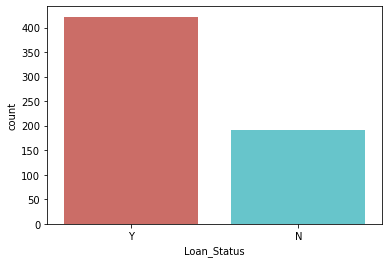

In [11]:
#Nombre de statuts selon l'acceptation ou le refus
sns.countplot(x='Loan_Status', data=credit, palette='hls')
plt.show()

- Nous avons pu constater que la grande majorité des individus du dataset correspond à des **hommes**.
- La part des refus dans le total des dossiers est égal à **31,27**% ce qui tend à exprimer que les accords sont plus probables que l'inverse, dans ce champs de données.
- Finalement, nous pouvons constater l'importance de l'historique de crédit dans la décision du dossier. En effet, les personnes avec un prêt accordé **ont en moyenne déjà eu un prêt accepté (0,98)**, tandis que les individus s'étant vu refuser leur prêt ont tendance à avoir, **soit aucun crédit, soit un crédit (la valeur moyenne est 0,54, la répartition est plutot bien distribuée)**. Par conséquent, avoir un historique de crédit non vide est presque obligatoire pour obtenir un nouveau prêt. Cependant, cela ne garantit pas l'accord. 

### 1.3. Premier traitement des données

Il s'agit maintenant de gérer les données afin de les rendre utilisables dans les modèles qui suivront.

Tout d'abord, repérons les variables catégorielles à traiter.

In [12]:
#Variables catégorielles à traiter
variables_categorielles = None
variables_categorielles = ['Gender', 'Married', 'Education', 'Dependents', 'Self_Employed', 
                          'Credit_History','Property_Area']
print('Variables categorielles:', variables_categorielles)

Variables categorielles: ['Gender', 'Married', 'Education', 'Dependents', 'Self_Employed', 'Credit_History', 'Property_Area']


Il y en a 7 à traiter, parfois de manière différentes étant donné leur valeur.

Maintenant, regardons les valeurs nulles dans le dataset entier.

In [13]:
#Valeurs manquantes
credit.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Les valeurs manquantes ou nulles sont assez conséquentes dans beaucoup de colonnes, pour gérer cela, la fonction 
```fillna``` gère très bien le problème. Il suffit de spécifier par quoi doit être remplacé la valeur manquante (dans notre cas concernant les montants des prêts, par la médiane).
En ce qui concerne les autres valeurs manquantes, ```dropna``` se charge de supprimer la ligne complète si une valeur manquante est présente.

In [14]:
#On remplace les valeurs manquantes de la colonne LoanAmount par la médiane de la colonne
credit['LoanAmount'].fillna((credit['LoanAmount'].median()), inplace = True)
#On supprime toutes les autres valeurs manquantes
credit.dropna(inplace=True)

credit.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Le dataset est maintenant sans aucunes valeurs manquantes ce qui nous permet de faire un début d'analyse 

In [15]:
#Nouvelles caractéristiques du dataset
credit.shape

(499, 13)

In [16]:
#Changement du type des valeurs de l'historique de crédit et du temps des prêts en entier
credit.Credit_History = credit.Credit_History.astype(int)
credit.Loan_Amount_Term = credit.Loan_Amount_Term.astype(int)
credit.Loan_Amount_Term

0      360
1      360
2      360
3      360
4      360
      ... 
609    360
610    180
611    360
612    360
613    360
Name: Loan_Amount_Term, Length: 499, dtype: int64

---------

## 2. Analyse Statistique

Passons maintenant à une analyse plus précise des données de crédit concernant les **499 dossiers** à l'aide premièrement de tableaux croisés pour mettre en relation les différentes variables puis en se concentrant sur les variables elles mêmes.

### 2.1. A l'aide de tableaux croisés

Les tableaux croisés permettent comme leur nom l'indique, de croiser des données pour en sortir des résultats plus ou moins intéressants.

Commençont par créer un tableaux croisé avec la fonction ```crosstab```de la librairie pandas. On choisit une normalisation par colonnes pour améliorer les résultats.

In [17]:
#Création d'un tableau croisé entre le statut du crédit et la notion de mariage des individus
pd.crosstab(credit['Loan_Status'], credit.Married, normalize='columns')

Married,No,Yes
Loan_Status,,
N,0.382857,0.280864
Y,0.617143,0.719136


On observe une différence entre les individus mariés et non mariés lorsqu'il s'agit de l'accord du prêt. En effet, **71% des individus mariés se voient un prêt octroyé** tandis que seulement **61% des non mariés ont un accord**. Il faut retenir que le **fait d'être marié augmente les chances d'obtenir un prêt**, cela ne garantit pas forcément l'accord mais ne pas être marié rend les choses moins faciles, du point de vue statistique (les données sont normalisées pour rendre compte au mieux des écarts).

Pour rendre l'analyse plus simple et plus belle, créer une fonction qui construira un tableau croisé et qui le sortira sous forme de matrice est une bonne idée. Ainsi, on utilise ```heatmap```de la librairie seaborn pour rendre le résultat plus agrable à regarder. <br>
Le choix de la normalisation reste le même.

In [18]:
#Fonction de création de heatmap
def crossheat(col1, col2, color):
    sns.heatmap(pd.crosstab(col1, col2, normalize='columns'),
            cmap=color, annot=True, cbar=False)

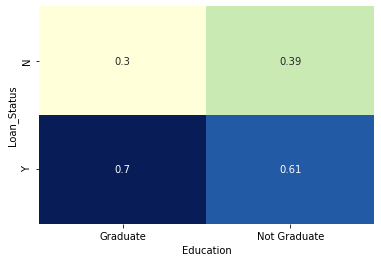

In [19]:
#Statut du crédit et éducation
crossheat(credit.Loan_Status, credit.Education, "YlGnBu")

On constate que le type d'éducation a un impact plutot neutre sur le statut final du crédit même si l'on voit une différence entre être diplomé du supérieur et ne pas l'être. En effet, **70% des diplomés du supérieur ont eut un "Oui"** tandis que **les non diplomés ont 8 points de percentage de moins**.

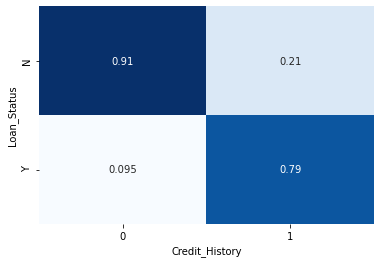

In [20]:
#Statut du crédit et historique de crédit
crossheat(credit.Loan_Status, credit.Credit_History, "Blues")

Concernant l'historique de crédit, on constate dans ce cas que si l'agent a contracté un crédit auparavant, **il aura beaucoup plus de chance d'obtenir un nouveau un crédit** et inversement pour quelqu'un qui n'en a pas déjà eu.

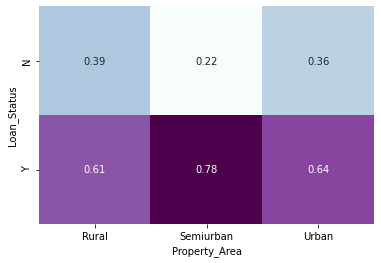

In [21]:
#Statut du crédit et zone de logement
crossheat(credit.Loan_Status, credit.Property_Area, "BuPu")

Finalement, on observe que **les individus vivant en zone semi-urbaine ont plus de chance de se faire accepter leur dossier** que les individus vivant en zone rurale ou purement urbaine.

### 2.2. En réalisant une analyse univariée

Le but est d'observer certaines variables pour en sortir des résultats intéressants. <br>
Les ```boxplot``` et ```barplot``` de la librairie seaborn sont à la fois élégants et complets.

<AxesSubplot:>

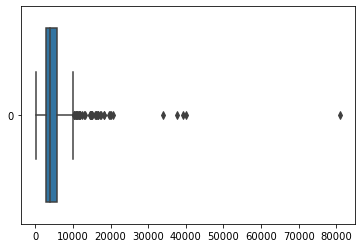

In [22]:
#Boxplot pour le revenu des agents
sns.boxplot(data=credit["ApplicantIncome"], orient='h')

On constate **des valeurs extrêmes** (aux alentours de 80 000 dollars) qui pourraient nuire au bon fonctionnement du modèle, il faudrait par conséquent les supprimer. Cela permettrait aussi de mieux observer la distribution du revenu des individus.

<AxesSubplot:>

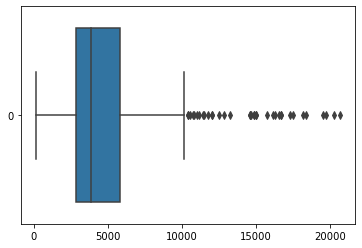

In [23]:
#Boxplot sans les valeurs extrêmes hautes
credit["ApplicantIncome"] = credit[credit["ApplicantIncome"] < 30000 ].ApplicantIncome
credit.dropna(inplace=True)
sns.boxplot(data = credit["ApplicantIncome"], orient='h')

Ainsi, on peut déduire que la plupart des demandeurs ont un revenu **entre 3000 dollars et 6000 dollars**. Le revenu médian est d'environ 4000 dollars et il y a quelque personne ayant des revenus entre 10 000 dollars et 20 000 dollars.

<AxesSubplot:>

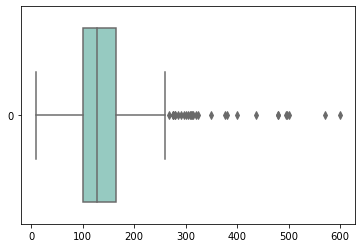

In [24]:
#Boxplot du montant emprunté
sns.boxplot(data = credit["LoanAmount"], palette="Set3", orient='h')

En moyenne, **les montants empruntés sont compris entre 100 000 dollars et 180 000 dollars**. On constate encore une fois des montants qui se détachent allant jusqu'à 600 000 dollars. 

<AxesSubplot:xlabel='Durée du prêt en mois', ylabel='Nombre'>

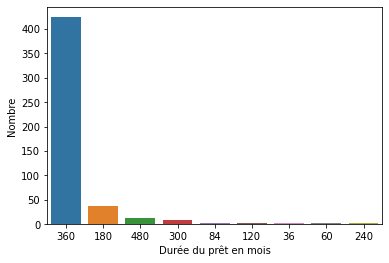

In [25]:
#Barplot sur la durée des prêts
Durée = pd.DataFrame(credit["Loan_Amount_Term"].value_counts())
Durée.reset_index(inplace=True)
Durée.columns = ["Durée du prêt en mois", "Nombre"]
Durée.sort_values(by='Nombre', ascending=False, inplace=True)

sns.barplot(x=Durée['Durée du prêt en mois'], y=Durée.Nombre, order = Durée['Durée du prêt en mois'])

La grande majorité des prêts ont **une durée de 360 mois (30 ans)** puis 180 mois (15 ans).

### 2.3. Data processing

Il s'agit dans cette sous partie, de préparer les données afin de les modéliser par la suite. Quelques procédure sont importantes pour rendre la modélisation cohérente et faisable.

Tout d'abord, **la transformation des variables qualitatives est importante pour que le modèle distingue correctement les valeurs**. Il faut donc remplacer les valeurs par des entiers, rendre binaire la plupart des variables catégorielles. <br>

La première colonne modifiée est celle de la variable expliquée, le statut du dossier.

In [26]:
#On remplace les valeurs de la colonne par des 0 et 1
credit.drop(labels=['Loan_ID'],axis=1, inplace=True)
credit['Loan_Status'].replace('Y',1,inplace=True)
credit['Loan_Status'].replace('N',0,inplace=True)

On fait de même avec les autres colonnes binaires.

In [27]:
#De texte à entier
credit.Gender = credit.Gender.replace(["Male", "Female"], [0, 1])
credit.Married = credit.Married.replace(["No", "Yes"], [0, 1])
credit.Education = credit.Education.replace(["Graduate", "Not Graduate"], [0, 1])
credit.Self_Employed = credit.Self_Employed.replace(["No", "Yes"], [0, 1])
credit.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,0,0,0,0,5849.0,0.0,128.0,360,1,Urban,1
1,0,1,1,0,0,4583.0,1508.0,128.0,360,1,Rural,0
2,0,1,0,0,1,3000.0,0.0,66.0,360,1,Urban,1
3,0,1,0,1,0,2583.0,2358.0,120.0,360,1,Urban,1
4,0,0,0,0,0,6000.0,0.0,141.0,360,1,Urban,1


In [28]:
#Information sur le dataframe
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             494 non-null    int64  
 1   Married            494 non-null    int64  
 2   Dependents         494 non-null    object 
 3   Education          494 non-null    int64  
 4   Self_Employed      494 non-null    int64  
 5   ApplicantIncome    494 non-null    float64
 6   CoapplicantIncome  494 non-null    float64
 7   LoanAmount         494 non-null    float64
 8   Loan_Amount_Term   494 non-null    int64  
 9   Credit_History     494 non-null    int64  
 10  Property_Area      494 non-null    object 
 11  Loan_Status        494 non-null    int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 66.3+ KB


On constate beaucoup moins de colonnes de type "object".

In [29]:
#Un rappel des valeurs unique pour les colonnes "dependents" et "property area"
print(credit.Dependents.unique())
print(credit.Property_Area.unique())

['0' '1' '2' '3+']
['Urban' 'Rural' 'Semiurban']


Pour finir le data processing, il faut s'occuper des colonnes avec plus de deux valeurs qualitatives. Pour cela, le module ```LabelEncoder``` est puissant, il va définir une valeur (un entier) pour chaque différente valeur de la colonne. 
> Ainsi Urban, Rural, Semiurban deviendra 1, 2, 3. <br>

La méthode utilisée est appelée "One hot encoding" : transformer les valeurs "texte" en valeurs booléennes. 

In [30]:
#One hot encoding
label=LabelEncoder()
credit['Property_Area']=label.fit_transform(credit['Property_Area'])
credit['Dependents']=label.fit_transform(credit['Dependents'])
credit.sample(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
388,0,1,0,0,0,2333.0,2417.0,136.0,360,1,2,1
26,0,1,0,0,0,2799.0,2253.0,122.0,360,1,1,1
526,0,1,0,0,0,3775.0,0.0,110.0,360,1,1,1


Pour finir, regarder les corrélations entre les variables est très intéressant et apporte des observations utiles pour la suite. <br>
Pour cela, la fonction ```corr``` marche parfaitement, accompagnée de la ```heatmap``` de seaborn.

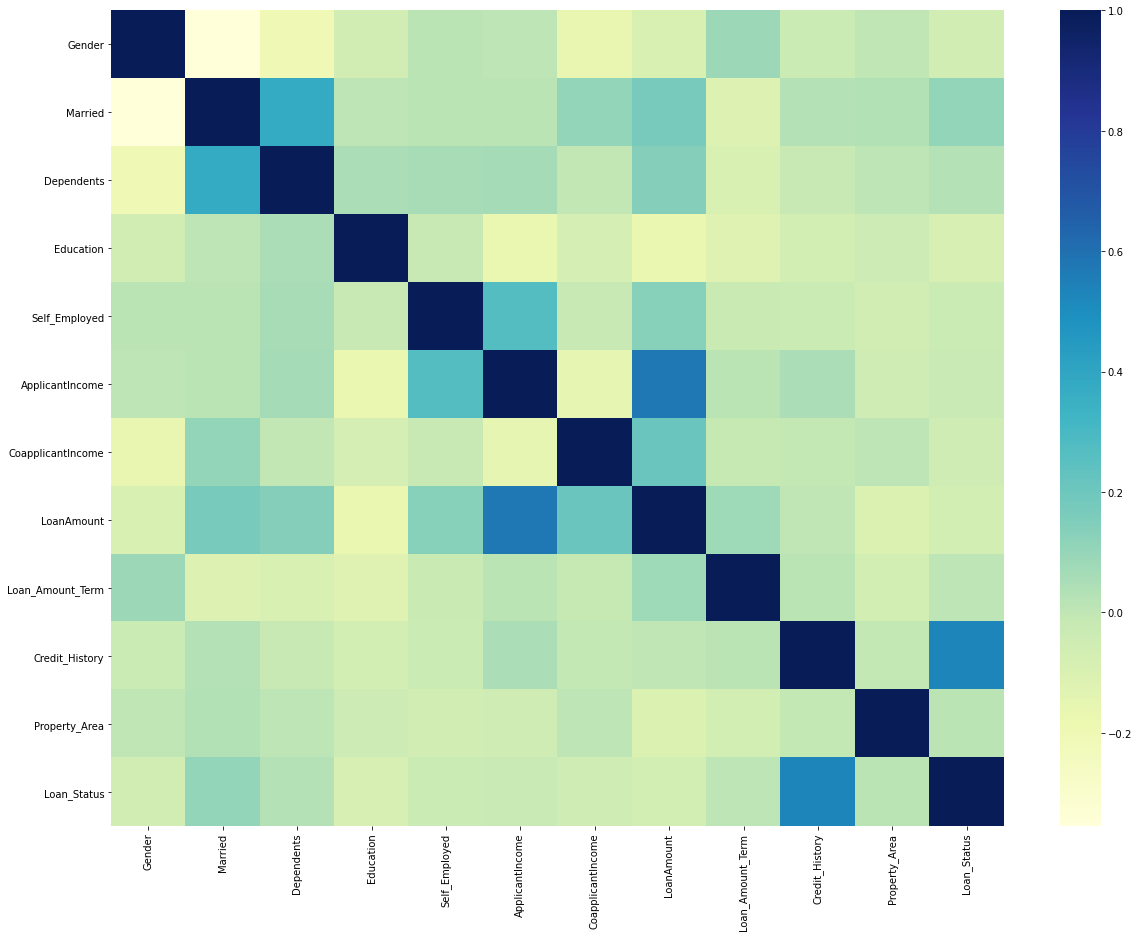

In [31]:
#Matrice de corrélation
corr = credit.corr()

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="YlGnBu")
plt.show()

Ce qui est le plus intéressant à regarder est la ligne ou colonne concernant le statut du crédit car elle met en avant les corrélations entre ce dernier et les autres variables. Plus la couleur est foncée, plus la corrélation est présente. **L'historique de crédit est une nouvelle fois la variable importante de cette analyse**.

---

## 3. Prédiction et modélisation

### 3.1 Modélisation du problème à partir d'une régression logistique

Passons maintenant à la partie prédictive de l'étude, l'objectif est de modéliser la situation afin d'obtenir des résultats escomptés si tant est que ces résultats soient possibles. En effet, tout dépend de la significativité des variables du modèle, ce que l'on cherche c'est à créer un modèle prédisant le statut final du dossier de prêt.

Pour cela, le modèle va utiliser les variables, dites, explicatives afin de trouver la meilleure combinaison et prédire le plus précisément le statut final du dossier.

La modélisation commence en séparant en deux le dataset, d'une partie, on retrouvera la variable expliquée "Y" et de l'autre les variables explicatives "X". Par la suite, il est très important de distinguer les données d'apprentissage avec les données de test pour ne pas sur-estimer la puissance du modèle et ke tester sur des variables utilisées dans l'apprentissage. Ainsi, la fonction ```train_test_split``` va séparer chaque partie en deux (train et test).

In [32]:
#Séparation du dataset
y = credit['Loan_Status']
X = credit.drop('Loan_Status', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Ensuite, il s'agit d'entrainer le modèle choisit, en l'occurrence ce sera une régression logistique. Pour ce faire, la librarie scikit-learn possède une fonction ```LogisticRegression``` permettant d'importer un modèle de régression dans le but de l'entrainer sur les données proposées. Une fois importer, il faut "fit" le modèle c'est à dire estimer les meilleurs paramètres selon les données ce qui constituera le nouveau modèle de prédiction à utiliser sur les données de test.

La dernière étape correspond à l'évaluation, on va prédire les valeurs sur la base de test et comparer les résultats avec les vraies valeur de "Y" (dans "y_test").

In [33]:
#Régression logistique
LR = LogisticRegression()
#Estimation
LR.fit(X_train, y_train)

#Prediction
y_predict = LR.predict(X_test)
print(classification_report(y_test, y_predict))

#Evaluation
LR_SC = accuracy_score(y_predict,y_test)
print(f"{round(LR_SC*100,2)}% de précision")

              precision    recall  f1-score   support

           0       0.81      0.50      0.62        44
           1       0.82      0.95      0.88       105

    accuracy                           0.82       149
   macro avg       0.82      0.73      0.75       149
weighted avg       0.82      0.82      0.80       149

81.88% de précision


Différentes données d'évaluation ressortent via la fonction ```accuracy_score```, dont la précision. Dans ce cas, elle est de 82%, cependant, il ne faut pas prendre ce résultat comme acquis mais plutôt regarder de près tous les autres. En effet, ces scores d'évaluation reflètent la manière dont la modèle à prédit les bonnes valeurs mais aussi les mauvaises: Vrai positif, Faux positif, Vrai négatif et Faux négatif.

Ici on constate différentes mesures : **la précision, le recall et le f1-score**. Chacune concerne la partie positive (1) ou négative (0). Le recall, par exemple, correspond à la part de Vrais positifs dans le total des positifs (positif dans le vrai dataset y_test). La précision, correspond elle, a la part de Vrais positifs dans le total des positifs prédits (donc en partie dans les faux positifs, mauvaises prédictions).

On observe que les **Vrais positifs sont plutôt bien répartis** donc qu'il y a peu de faux négatifs. Par contre, **la prédiction du statut No est, elle, moins bonne (recall 0 à 0,50)**. Cela veut dire qu'il y a eu peu de mauvaises
prédictions positives mais que par conséquent, les prédictions négatives ont été mauvaises.

In [34]:
#Matrice de confusion
confusion_matrix = metrics.confusion_matrix(y_test, y_predict, labels=[0,1])
pd.DataFrame(confusion_matrix)

,0,1
0,22,22
1,5,100


On constate grâce à la fonction de matrice de confusion qui crée une matrice mêlant les FP, TP, FN et FP, que le nombre de faux positifs est élevé, 22. Cela veut dire que parmi les vrai négatifs de y_test, la moitité a été mal prédite. Il faut donc essayer d'améliorer le modèle afin qu'il fasse moins d'erreurs à ce niveau la.

### 3.2 Modification des données d'apprentissage afin d'améliorer le modèle

Pour améliorer le modèle, une possibilité est de regarder tout d'abord, la significativité des coefficients créés par la régression. Pour cela, la librairie statsmodels possède une fonction ```summary``` qui donne beaucoup d'information concernant les variables explicatives.

In [35]:
#Nouvelle régression et "summary"
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.476672
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.236     
Dependent Variable: Loan_Status      AIC:              492.9521  
Date:               2021-02-05 21:29 BIC:              539.1799  
No. Observations:   494              Log-Likelihood:   -235.48   
Df Model:           10               LL-Null:          -308.09   
Df Residuals:       483              LLR p-value:      3.5820e-26
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Gender            -0.2654   0.3163 -0.8388 0.4016 -0.8854  0.3547
Married            0.4627   0.2706  1.7097 0.0873 -0.0677  0.9931


On constate facilement que beaucoup de variables ont des coefficients non significativement différents de 0 (p value supérieure à 5%). Ainsi, il serait pertinent de garder les seules variables cohérentes.

In [36]:
#Suppression des variables non significatives et nouveau summary
cols=["Education", "Loan_Amount_Term", "Credit_History"] 
X=credit[cols]
y=credit['Loan_Status']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.491486
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.212     
Dependent Variable: Loan_Status      AIC:              491.5882  
Date:               2021-02-05 21:29 BIC:              504.1959  
No. Observations:   494              Log-Likelihood:   -242.79   
Df Model:           2                LL-Null:          -308.09   
Df Residuals:       491              LLR p-value:      4.4088e-29
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Education         -0.5158   0.2649 -1.9473 0.0515 -1.0349  0.0033
Loan_Amount_Term  -0.0052   0.0010 -5.3792 0.0000 -0.0070 -0.0033


Le modèle à légèrement gagné en efficacité (AIC plus faible), cependant on constate que la variable éducation est devenue non significative. On décide tout de même de la conserver.

Une autre possibilité d'amélioration est d'ajouter des variables en les redéfinissant, c'est à dire en binéarisant une variable qui ne le serait. Par exemple, la variable concernant le revenu de la personne peut être divisée en plusieurs variables (haut revenu, bas revenu...).

In [37]:
#Description de la colonne des revenus
credit["ApplicantIncome"].describe()

count      494.000000
mean      4921.087045
std       3401.004105
min        150.000000
25%       2877.500000
50%       3848.000000
75%       5811.250000
max      20667.000000
Name: ApplicantIncome, dtype: float64

In [38]:
#Division de la variable revenu en 4
credit["FaibleRevenu"] = credit["ApplicantIncome"] <= 2877.500000 
credit["MoyenRevenu1"] = (credit["ApplicantIncome"] > 2877.500000) & (credit["ApplicantIncome"] <= 3848.000000)
credit["MoyenRevenu2"] = (credit["ApplicantIncome"] > 3848.000000) & (credit["ApplicantIncome"] <= 5811.250000)
credit["HautRevenu"] = credit["ApplicantIncome"] > 5811.250000 

credit.FaibleRevenu = credit.FaibleRevenu.replace([False, True], [0, 1])
credit.MoyenRevenu1 = credit.MoyenRevenu1.replace([False, True], [0, 1])
credit.MoyenRevenu2 = credit.MoyenRevenu2.replace([False, True], [0, 1])
credit.HautRevenu = credit.HautRevenu.replace([False, True], [0, 1])

In [39]:
#Suppression des valeurs nulles
credit.dropna(inplace=True)
credit.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
FaibleRevenu         0
MoyenRevenu1         0
MoyenRevenu2         0
HautRevenu           0
dtype: int64

In [40]:
#Nouveau summary avec les nouvelles variables
cols=["Education", "Loan_Amount_Term", "Credit_History", "FaibleRevenu", "MoyenRevenu1",
     "MoyenRevenu2", "HautRevenu"] 
X=credit[cols]
y=credit['Loan_Status']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.481305
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.228     
Dependent Variable: Loan_Status      AIC:              489.5291  
Date:               2021-02-05 21:29 BIC:              518.9469  
No. Observations:   494              Log-Likelihood:   -237.76   
Df Model:           6                LL-Null:          -308.09   
Df Residuals:       487              LLR p-value:      7.3367e-28
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Education         -0.4277   0.2806 -1.5244 0.1274 -0.9777  0.1222
Loan_Amount_Term  -0.0003   0.0018 -0.1673 0.8672 -0.0038  0.0032


On observe une légère amélioration du modèle ainsi que la significativité des variables créées. Les coefficients de ces variables ne sont pas très cohérent au vu de ce à quoi ils réfèrent.

In [41]:
#Re séparation du nouveau dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [42]:
#Nouveau modèle
LR = LogisticRegression()
#Estimation
LR.fit(X_train, y_train)

#Prédiction
y_predict = LR.predict(X_test)
print(classification_report(y_test, y_predict))

#Evaluation
LR_SC = accuracy_score(y_predict,y_test)
print(f"{round(LR_SC*100,2)}% de précision")

              precision    recall  f1-score   support

           0       0.91      0.48      0.63        44
           1       0.82      0.98      0.89       105

    accuracy                           0.83       149
   macro avg       0.87      0.73      0.76       149
weighted avg       0.85      0.83      0.81       149

83.22% de précision


Le modèle est effectivement plus précis mais si d'un coté **on gagne en "precision"**, de l'autre, **on perd en "recall" négatif**, ce qui était le contraire de l'objectif de départ.

In [43]:
#Matrice de confusion
confusion_matrix = metrics.confusion_matrix(y_test, y_predict, labels=[0,1])
pd.DataFrame(confusion_matrix)

,0,1
0,21,23
1,2,103


Effectivement, **le nombre de Vrais positifs s'est amélioré** tandis que **le nombre de Faux positifs s'est dégradé**.

## 4. Conclusion

Pour conclure, le jeu de données utilisé est un jeu de donnée intéressant du point de vue des variables qu'il met en avant. Il pose problème sur le fait qu'il n'est pas très vaste et donc ne permet pas l'amélioration réelle du moèdle. De plus, une seule réelle variable explicative sort du lot en montrant une corrélation significative et cela est compliqué pour arriver à des prédiction correctes. Globalement, il manque de données même si le modèle pourrait être améliorer en modifiant les paramètres ou en changeant l'algorithme d'apprentissage lui même (forêt aléatoire, arbre de décisions...).